In [1]:
#Mount the drive to access image and annotation folders
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My\ Drive/keras-yolo3

/content/gdrive/My Drive/keras-yolo3


## Visualize BloodImage_00001

In [4]:
#import all packages 
import numpy as np 
import os
import xml.etree.ElementTree as ET
import cv2
from google.colab.patches import cv2_imshow
from keras.models import load_model

Using TensorFlow backend.


In [0]:
#parse the annotation file, store xmin, ymin, xmax, ymax into instances and store labels 
def parse_xml(ann_dir, img_dir, labels=[]):

  all_insts = []
  seen_labels = {}
        
  for ann in sorted(os.listdir(ann_dir)):
    img = {'object':[]}
    tree = ET.parse(ann_dir + ann)

            
    for elem in tree.iter():
      if 'filename' in elem.tag:
        img['filename'] = img_dir + elem.text
      if 'width' in elem.tag:
        img['width'] = int(elem.text)
      if 'height' in elem.tag:
        img['height'] = int(elem.text)
      if 'object' in elem.tag or 'part' in elem.tag:
        obj = {}
                    
        for attr in list(elem):
          if 'name' in attr.tag:
            obj['name'] = attr.text

            if obj['name'] in seen_labels:
              seen_labels[obj['name']] += 1
            else:
              seen_labels[obj['name']] = 1
                            
            if len(labels) > 0 and obj['name'] not in labels:
              break
            else:
              img['object'] += [obj]
                                
        if 'bndbox' in attr.tag:
          for dim in list(attr):
            if 'xmin' in dim.tag:
              obj['xmin'] = int(round(float(dim.text)))
            if 'ymin' in dim.tag:
              obj['ymin'] = int(round(float(dim.text)))
            if 'xmax' in dim.tag:
              obj['xmax'] = int(round(float(dim.text)))
            if 'ymax' in dim.tag:
              obj['ymax'] = int(round(float(dim.text)))

      if len(img['object']) > 0:
        all_insts += [img]
                        
    return all_insts, seen_labels

In [0]:
#parse the xml file
labels = ["Platelets", "RBC", "WBC"]
valid_instance, valid_labels = parse_xml("valid_annot_folder/", "test_image_folder/", labels)

test_image_folder/BloodImage_00001.jpg


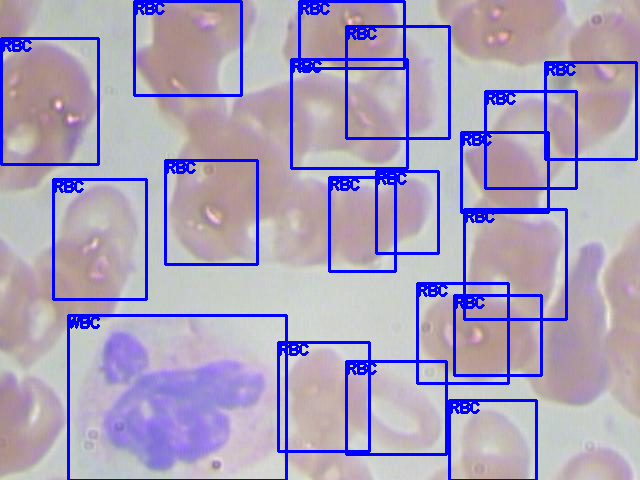

In [7]:
#visualize the image with bounding boxs
Bloodimage = valid_instance[0]
print(Bloodimage['filename'])
img = cv2.imread(Bloodimage['filename'])
for obj in Bloodimage['object']:
  cv2.rectangle(img, (obj['xmin'],obj['ymin']),(obj['xmax'],obj['ymax']), (255,0,0),2)
  cv2.putText(img, obj['name'],(obj['xmin'], obj['ymin']+12), cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * img.shape[0], (255,0,0), 2)
cv2_imshow(img)


## YOLO V3 Modeling

In [0]:
#import tensorflow functions 
%tensorflow_version 2.x
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    LeakyReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
    BatchNormalization
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (binary_crossentropy, sparse_categorical_crossentropy)

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
#create the convolution block 
def darkConv(x, filters, size, strides = 1, batch_norm = True):
  if strides == 1:
    padding = 'same'
  else:
    x = ZeroPadding2D(((1,0),(1,0)))(x)
    padding = 'valid'
  x = Conv2D(filters = filters, kernel_size = size, strides = strides, padding = padding,use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
  if batch_norm:
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.1)(x)
  return x

In [0]:
#create the residual block
def darkResidual(x, filters):
  prev = x
  x = darkConv(x, filters//2, 1)
  x = darkConv(x, filters, 3)
  x = Add()([prev,x])
  return x

In [0]:
#create the darknet block
def darkBlock(x, filters, blocks):
  x = darkConv(x, filters, 3, strides = 2)
  for _ in range(blocks):
    x = darkResidual(x, filters)
  return x

In [0]:
#construct the darknet
def darkNet(name=None):
    x = inputs = Input([None, None, 3])
    x = darkConv(x, 32, 3)
    x = darkBlock(x, 64, 1)
    x = darkBlock(x, 128, 2)  # skip connection
    x = x_36 = darkBlock(x, 256, 8)  # skip connection
    x = x_61 = darkBlock(x, 512, 8)
    x = darkBlock(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)

In [0]:
#construct the yolo model 
def yoloConv(x0, filters, name = None):
  if isinstance(x0, tuple):
    inputs = Input(x0[0].shape[1:]), Input(x0[1].shape[1:])
    x, x_skip = inputs
    print(x, x_skip)

    x = darkConv(x, filters, 1)
    x = UpSampling2D(size = (2,2))(x)
    x = Concatenate()([x, x_skip])
  else:
    x = inputs = Input(x0.shape[1:])

  x = darkConv(x, filters, 1)
  x = darkConv(x, filters*2, 3)
  x = darkConv(x, filters, 1)
  x = darkConv(x, filters*2, 3)
  x = darkConv(x, filters, 1)
  return Model(inputs, x)(x0)

In [0]:
#return the output 
def yoloOutput(x0, filters, anchors, classes, name = None):
  x = inputs = Input(x0.shape[1:])
  x = darkConv(x, filters*2, 3)
  x = darkConv(x, anchors*(classes+5), 1, batch_norm = False)
  x = Lambda(lambda x:tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2], anchors, classes+5)))(x)
  return Model(inputs, x)(x0)

In [0]:
def YoloV3(size=None, channels=3, anchors=yolo_anchors, masks=yolo_anchor_masks, classes=80):
  
    x = inputs = Input([size, size, channels])
    x_36, x_61, x = darkNet()(x)

    x = yoloConv(x, 512, name='yolo_conv_0')
    output_0 = yoloOutput(x, filters = 512, anchors = len(masks[0]), classes=80, name='yolo_output_0')

    x = yoloConv((x, x_61), 256, name='yolo_conv_1')
    output_1 = yoloOutput(x, filters = 256, anchors = len(masks[1]), classes=80, name='yolo_output_1')

    x = yoloConv((x, x_36),128, name='yolo_conv_2')
    output_2 = yoloOutput(x, filters = 128, anchors = len(masks[2]), classes=80, name='yolo_output_2')

    return Model(inputs, (output_0, output_1, output_2), name='yolov3')

In [0]:
model = YoloV3(size = 416, classes=80)

In [0]:
model.summary()

## Predict the bounding box 

In [8]:
#load the pre-trained model
model = load_model('darknet53.h5',compile = False)

In [0]:
#create a bounding box class to store all box information 
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objectiveness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objectiveness = objectiveness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

In [0]:
def sigmoid_func(input):
  output = 1./(1.+ np.exp(-input))
  return output

In [0]:
#intepret the yolo results 
def transform_yolo(output, anchors, objective_thre, non_max_suppression_thre, size):
  grid_size = output.shape[0]

  nb_anchor_box = 3
  nb_class = 3
  print(output.shape)
  #reshape the output to (grid, grid, 3, (nb_class+5))
  output = output.reshape((grid_size, grid_size, nb_anchor_box, -1))
  print(output.shape)

  #print(output.shape)
  #grid, grid
  output[...,:2] = sigmoid_func(output[...,:2])
  #coordinates+class+obj_score
  output[...,4:] = sigmoid_func(output[...,4:])
  #slice at the fifth 
  output[...,5:] = output[...,4][...,np.newaxis]*output[...,5:]
  output[...,5:] *= output[...,5:] > objective_thre

  boxes = []
  confidences = []
  class_ids = []
  #iterate through each grid 
  for i in range(grid_size*grid_size):
    row = i/ grid_size
    col = i% grid_size
    #iterate through each anchor box

    for j in range(nb_anchor_box):
      obj_score  = output[int(row)][int(col)][j][4] #the 4th is objective_score 

      if(obj_score.all()<= objective_thre): continue #if the objective score is greater than the threshold, keep the bo

      
      x = output[int(row)][int(col)][j][0]
      y = output[int(row)][int(col)][j][1]
      w = output[int(row)][int(col)][j][2]
      h = output[int(row)][int(col)][j][3]

      #bounding box preidction
      x = (col+x)/grid_size #center x
      y = (row+y)/grid_size #center y
      w = anchors[2*j+0]*np.exp(w)/size 
      h = anchors[2*j+1]*np.exp(h)/size
      class_prob = output[int(row)][int(col)][j][5:]

      box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, obj_score, class_prob)
      

      '''
      boxes.append((x-w/2, y-h/2, x+w/2, y+h/2))
      confidences.append(float(obj_score))
      class_ids.append(class_prob)
      '''
      boxes.append(box)
  
  #print("intransformation",boxes[0])

  return boxes


In [0]:
#scale the coordinate to the image size
def scale_box(box, h, w, size):
  #width is greater than the height
  if(float(size)/w) < (float(size)/h):
    new_w = size
    new_h = (h*size)/w
  #height is greater than width
  else:
    new_h = size
    new_w = (w*size)/h

  x_offset = (size-new_w)/2./size
  #print(x_offset)
  x_scale = float(new_w)/size
  #print(x_scale)
  y_offset = (size-new_h)/2./size
  y_scale = float(new_h)/size

  #box = [(int((bb[0]-x_offset)/x_scale*w), int((bb[1]-x_offset)/x_scale*w), int((bb[2]-y_offset)/y_scale*h), int((bb[3]-y_offset)/y_scale*h)) for bb in box]
  
  '''
  box[0] = int((box[0]-x_offset)/x_scale*w)
  box[1] = int((box[1]-x_offset)/x_scale*w)
  box[2] = int((box[2]-y_offset)/y_scale*h)
  box[3] = int((box[3]-y_offset)/y_scale*h)
  '''

  for i in range(len(box)):
    box[i].xmin = int((box[i].xmin-x_offset)/x_scale*w)
    box[i].xmax = int((box[i].xmax-x_offset)/x_scale*w)
    box[i].ymin = int((box[i].ymin-y_offset)/y_scale*h)
    box[i].ymax = int((box[i].ymax-y_offset)/y_scale*h)



In [0]:
#calculate the intersect length
def overlap(interval_A, interval_B):
    xminA, xmaxA = interval_A
    xminB, xmaxB = interval_B

    if xminB < xminA:
        if xmaxB < xminA:
            return 0
        else:
            return min(xmaxA,xmaxB) - xminA
    else:
        if xmaxA < xminB:
             return 0
        else:
            return min(xmaxA,xmaxB) - xminB

In [0]:
#calculate the intersaction over union 
def box_iou(boxA, boxB):
    intersect_w = overlap([boxA.xmin, boxA.xmax], [boxB.xmin, boxB.xmax])
    intersect_h = overlap([boxA.ymin, boxA.ymax], [boxB.ymin, boxB.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = boxA.xmax-boxA.xmin, boxA.ymax-boxA.ymin
    w2, h2 = boxB.xmax-boxB.xmin, boxB.ymax-boxB.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

In [0]:
#calculate the intersaction over union (some issue??)
def box_intersection_over_union(boxA, boxB):
  xA = max(boxA.xmin, boxB.xmin)
  yA = max(boxA.ymin, boxB.ymin)
  xB = min(boxA.xmax, boxB.xmax)
  yB = min(boxA.ymax, boxB.ymax)
 
	# compute the area of intersection rectangle
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
  boxAArea = (boxA.xmax - boxA.xmin + 1) * (boxA.ymax - boxA.ymin + 1)
  boxBArea = (boxB.xmax - boxB.xmin + 1) * (boxB.ymax - boxB.ymin + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
  iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
  return iou

In [0]:
#compute the non-maximum suppression
def nms(boxes, non_max_suppression_thre):
  if len(boxes) > 0:
    #print(boxes[0].classes)
    nb_class = len(boxes[0].classes)
  else:
    return

  for i in range(nb_class):
    #select the highest confidence 
    sorted_idx = np.argsort([-box.classes[i] for box in boxes])
    print(sorted_idx.shape)

    for j in range(len(sorted_idx)):
      idx = sorted_idx[j]
      if boxes[idx].classes[i] == 0: continue
      for z in range(j+1, len(sorted_idx)):
        idx_z = sorted_idx[z]
        #compare two proposals and calculate the IOU if every other proposal. if greater, eliminate.
        if box_iou(boxes[idx], boxes[idx_z]) >= non_max_suppression_thre:
          boxes[idx_z].classes[i] = 0


In [0]:
#draw the bounding box 
def draw_boxes(image, boxes, labels, obj_thresh):
    for box in boxes:
        label_str = ''
        label = -1
    
        for i in range(len(labels)):
            if box.classes[i] > obj_thresh:
                label_str += labels[i]
                label = i
                print(labels[i] + ': ' + str(box.classes[i]*100) + '%')
           
        if label >= 0:
            cv2.rectangle(image, (box.xmin,box.ymin), (box.xmax,box.ymax), (255,0,0), 2)
            cv2.putText(image, label_str + ' ' + str(box.get_score()), (box.xmin, box.ymin+12), cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (255,0,0), 2)
    cv2_imshow(image)
           
    return image     

In [0]:
print(yolo[0].shape)
print(yolo[1].shape)
print(yolo[2].shape)

(1, 13, 13, 24)
(1, 26, 26, 24)
(1, 52, 52, 24)


## Intepret results for outputs at three scales

In [0]:
#define the parameters 
size = 416 
objective_thre = 0.5
non_max_suppression_thre = 0.45
anchors = [[81,96, 116,134, 147,182], [67,83, 68,98, 73,65], [25,33, 52,94, 56,71]]
labels = ["Platelets", "RBC", "WBC"]

#read the image and preprocess the image 
img = cv2.imread(Bloodimage['filename'])
h, w, channel = img.shape
if(float(size)/h) < (float(size)/w):
  w = (w*size)/h
  h = size
else:
  h = (h*size)/w
  w = size
     
resized_img = cv2.resize(img[:,:,::-1]/255., (int(w), int(h)))
print(resized_img.shape)
new_img = np.ones((size, size, 3))*0.5
new_img[int((size-h)//2):int((size+h)//2), int((size-w)//2):int((size+w)//2), :] = resized_img
new_img = np.expand_dims(new_img, 0)
print(new_img.shape)

#bx, by, bw, bh, objectiveness score, class 
#N*N*[3*(4+1+80)] 
#4 bounding boxes, 1 objectiveness score, 80 class predictions 

#make ths prediction 
yolo = model.predict(new_img)


(312, 416, 3)
(1, 416, 416, 3)


In [0]:
h, w, channel = img.shape
boxes = []

for i in range(len(yolo)):
  boxes += transform_yolo(yolo[i][0], anchors[i], objective_thre, non_max_suppression_thre, size)
  #boxes += box
  #confidences += confidence
  #class_ids += class_id

#change the box back to scale 
'''
for j in range(len(boxes)):
  scale_box(boxes[j], h, w, size)
'''
scale_box(boxes, h, w, size)


(13, 13, 24)
(13, 13, 3, 8)
(26, 26, 24)
(26, 26, 3, 8)
(52, 52, 24)
(52, 52, 3, 8)


In [0]:
#non-max suppression
nms(boxes, non_max_suppression_thre)

(10647,)
(10647,)
(10647,)


WBC: 90.24670124053955%
RBC: 90.24074673652649%
RBC: 83.85323286056519%
RBC: 74.21436905860901%
RBC: 68.50565671920776%
RBC: 81.28851056098938%
RBC: 64.25243616104126%
RBC: 83.93005728721619%
RBC: 93.04145574569702%
RBC: 84.31093096733093%
RBC: 83.2257866859436%
RBC: 62.80637979507446%
RBC: 70.98373174667358%
RBC: 90.86697101593018%
RBC: 60.55258512496948%
RBC: 54.12585735321045%
RBC: 68.48822236061096%
RBC: 76.68331265449524%
RBC: 64.30745124816895%
RBC: 75.43242573738098%
RBC: 85.39425730705261%
RBC: 67.16822981834412%
RBC: 65.52183032035828%
RBC: 64.39920663833618%
RBC: 60.158371925354004%
RBC: 70.48656344413757%
RBC: 84.63352918624878%
RBC: 77.36082077026367%
RBC: 73.62914681434631%
RBC: 91.87228679656982%
RBC: 94.9922263622284%


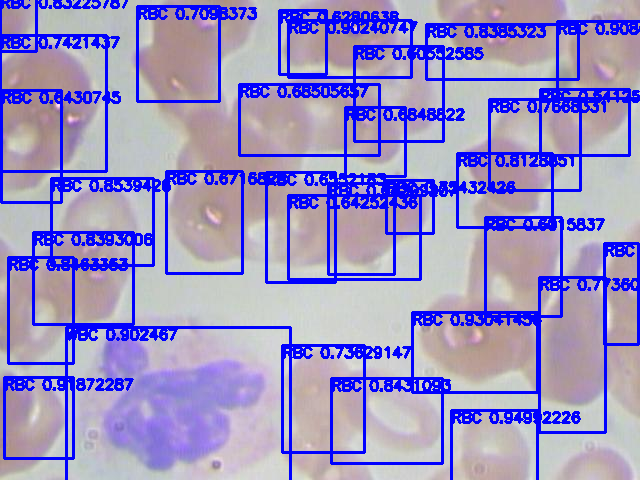

True

In [0]:
#draw the bounding box
img = cv2.imread(Bloodimage['filename'])
draw_boxes(img, boxes, labels, objective_thre)
cv2.imwrite('Blood_cell_detected.jpg', (img).astype('uint8')) 

## Image detection

In [0]:
def detect_image(img,objective_thre, non_max_suppression_thre, anchors, labels):
  h, w, channel = img.shape
  if(float(size)/h) < (float(size)/w):
    w = (w*size)/h
    h = size
  else:
    h = (h*size)/w
    w = size
      
  resized_img = cv2.resize(img[:,:,::-1]/255., (int(w), int(h)))
  print(resized_img.shape)
  new_img = np.ones((size, size, 3))*0.5
  new_img[int((size-h)//2):int((size+h)//2), int((size-w)//2):int((size+w)//2), :] = resized_img
  new_img = np.expand_dims(new_img, 0)
  print(new_img.shape)

#bx, by, bw, bh, objectiveness score, class 
#N*N*[3*(4+1+80)] 
#4 bounding boxes, 1 objectiveness score, 80 class predictions 

#make ths prediction 
  yolo = model.predict(new_img)
  boxes = []

  for i in range(len(yolo)):
    boxes += transform_yolo(yolo[i][0], anchors[i], objective_thre, non_max_suppression_thre, size)
    #boxes += box
    #confidences += confidence
    #class_ids += class_id

  #change the box back to scale 
  '''
  for j in range(len(boxes)):
    scale_box(boxes[j], h, w, size)
  '''
  scale_box(boxes, h, w, size)
  nms(boxes, non_max_suppression_thre)
  draw_boxes(img, boxes, labels, objective_thre)
  cv2.imwrite('Blood_cell_detected.jpg', (img).astype('uint8')) 
  return img




(312, 416, 3)
(1, 416, 416, 3)
(13, 13, 24)
(13, 13, 3, 8)
(26, 26, 24)
(26, 26, 3, 8)
(52, 52, 24)
(52, 52, 3, 8)
(10647,)
(10647,)
(10647,)
WBC: 90.24670124053955%
RBC: 90.24074673652649%
RBC: 83.85324478149414%
RBC: 74.21436309814453%
RBC: 68.50564479827881%
RBC: 81.28851056098938%
RBC: 64.2524242401123%
RBC: 83.93006324768066%
RBC: 93.04145574569702%
RBC: 84.31093096733093%
RBC: 83.2257866859436%
RBC: 62.80643939971924%
RBC: 70.98373174667358%
RBC: 90.86697101593018%
RBC: 60.552603006362915%
RBC: 54.12583351135254%
RBC: 68.48819851875305%
RBC: 76.6832947731018%
RBC: 64.3074631690979%
RBC: 75.43243169784546%
RBC: 85.39425730705261%
RBC: 67.16826558113098%
RBC: 65.52183032035828%
RBC: 64.39926028251648%
RBC: 60.15838384628296%
RBC: 70.48654556274414%
RBC: 84.63351726531982%
RBC: 79.13692593574524%
RBC: 77.36082673072815%
RBC: 73.62915277481079%
RBC: 91.87229871749878%
RBC: 94.99221444129944%


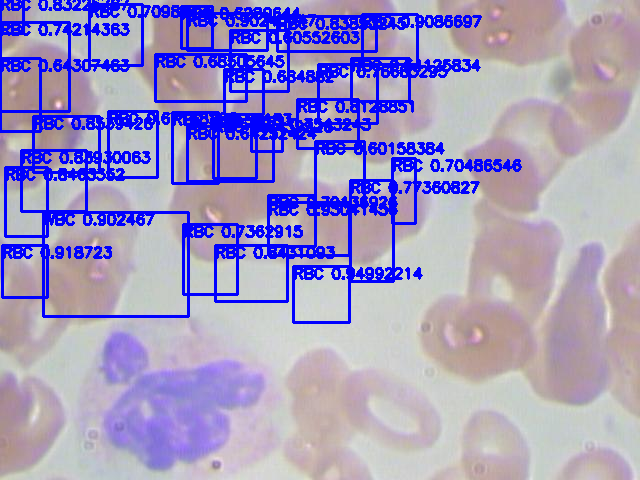

In [20]:
#parameters
size = 416 
objective_thre = 0.5
non_max_suppression_thre = 0.45
anchors = [[81,96, 116,134, 147,182], [67,83, 68,98, 73,65], [25,33, 52,94, 56,71]]
labels = ["Platelets", "RBC", "WBC"]

#read the image and preprocess the image 
img = cv2.imread(Bloodimage['filename'])
detect_image(img, objective_thre, non_max_suppression_thre, anchors, labels)

## Video detection

In [0]:
#video detection

#parameters
size = 416 
objective_thre = 0.5
non_max_suppression_thre = 0.5
anchors = [[116,90,  156,198,  373,326],  [30,61, 62,45,  59,119], [10,13,  16,30,  33,23]]
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
              "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
              "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
              "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
              "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
              "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
              "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
              "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
              "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

#specify video 
video_path = "./cuba.MOV"
vid = cv2.VideoCapture(video_path)
video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
video_fps       = vid.get(cv2.CAP_PROP_FPS)
video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))

#specify video path
outputPath = "./detected_video.MOV"
out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)

'''
isOutput = True if output_path != "" else False
if isOutput:
  print("!!! TYPE:", type(output_path), type(video_FourCC), type(video_fps), type(video_size))
  out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)
'''
accum_time = 0
curr_fps = 0
fps = "FPS: ??"
prev_time = timer()
while True:
  return_value, frame = vid.read()
  image = Image.fromarray(frame)
  image = detect_image(image, objective_thre, non_max_suppression_thre, anchors, labels)
  result = np.asarray(image)
  curr_time = timer()
  exec_time = curr_time - prev_time
  prev_time = curr_time
  accum_time = accum_time + exec_time
  curr_fps = curr_fps + 1
  if accum_time > 1:
    accum_time = accum_time - 1
    fps = "FPS: " + str(curr_fps)
    curr_fps = 0
  cv2.putText(result, text=fps, org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.50, color=(255, 0, 0), thickness=2)
  cv2.namedWindow("result", cv2.WINDOW_NORMAL)
  cv2.imshow("result", result)
  if isOutput:
    out.write(result)
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break